# Load data

In [1]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2021-08-16 10:03:35--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  4.24MB/s    in 4.4s    

2021-08-16 10:03:42 (4.24 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [329]:
import matplotlib.pyplot as plt   
import numpy as np
import matplotlib.image as mpimg
import cv2
from tensorflow.keras.utils import to_categorical
import operator

In [330]:
d = np.load('Data.npz')
print(d.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [331]:
print(d['train_labels'].shape)

(7007, 1)


Train: X=(7007, 28, 28, 3), y=(7007, 1)
Test: X=(2005, 28, 28, 3), y=(2005, 1)


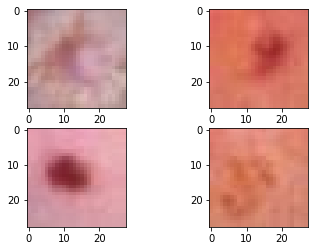

In [332]:
print('Train: X=%s, y=%s' % (d['train_images'].shape, d['train_labels'].shape))
print('Test: X=%s, y=%s' % (d['test_images'].shape, d['test_labels'].shape))
# plot some images
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.imshow(d['train_images'][i])
plt.show()

In [333]:
data = {key: d[key] for key in d.files}

In [334]:
data['train_images'][0].shape

(28, 28, 3)

# Preprocessing

In [335]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

## Resize Images
## Remove noise(Denoise)


In [336]:
# resize images
def resize_image(data):
    img = data
    print(len(img))
    print('Original size',img[0].shape)
    # setting dim of the resize
    height = 32
    width = 32
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[0].shape)
    
    # Visualizing one of the images in the array
    original = res_img[0]
    display_one(original)

    # Remove noise
    # Gaussian
    #no_noise = []
    #for i in range(len(res_img)):
    #  blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
    #  no_noise.append(blur)

    #image = no_noise[0]
    #display(original, image, 'Original', 'Blured')

    return np.array(res_img)

7007
Original size (28, 28, 3)
RESIZED (32, 32, 3)


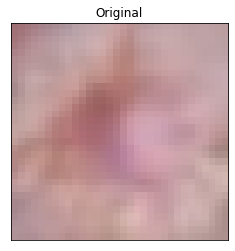

1003
Original size (28, 28, 3)
RESIZED (32, 32, 3)


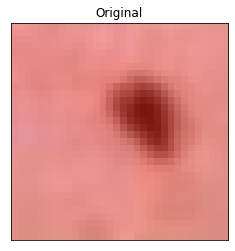

2005
Original size (28, 28, 3)
RESIZED (32, 32, 3)


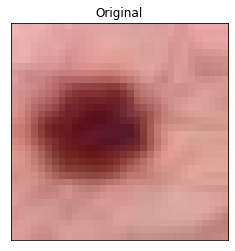

In [337]:
# Resize all images
data = dict({key: resize_image(data[key]) for key in d.files[:3]}, **{key: data[key] for key in d.files[3:]})

In [338]:
data['val_images'][6].shape

(32, 32, 3)

In [339]:
# image = data['val_images'][0].reshape((-1,) + data['val_images'][0].shape)
# train_gen = datagen.flow(image, [0], batch_size=1, shuffle=False)
# X, y = train_gen.next()
# plt.imshow(X[0].astype(np.uint8))

# train_imgs, train_labels = [], []
# for image, label in zip(data['train_images'], data['train_labels']):
#   image = image.reshape((-1,) + image.shape)
#   rain_gen = datagen.flow(image, [0], batch_size=1, shuffle=False)
#   X, y = train_gen.next()
#   train_imgs.append(X[0].astype(np.uint8))
#   train_labels.append(label)

In [340]:
#data['train_images'] = np.concatenate([np.array(train_imgs), data['train_images']])
#data['train_labels'] = np.concatenate([np.array(train_labels), data['train_labels']])

In [341]:
#data['train_images'].shape

In [342]:
#plt.imshow(train_imgs[1])

In [343]:
#X[0].astype(np.uint8).shape

In [344]:
#plt.imshow(data['train_images'][1].astype(np.uint8))

# Concat train, val and test, then shuffle and split

In [345]:
combined_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])
combined_labels = np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']])

In [346]:
combined_images.shape

(10015, 32, 32, 3)

In [347]:
c = np.c_[combined_images.reshape(len(combined_images), -1), combined_labels.reshape(len(combined_labels), -1)]

In [348]:
np.random.shuffle(c)

In [349]:
shuffled_images = c[:, :combined_images.size//len(combined_images)].reshape(combined_images.shape)
shuffled_labels = c[:, combined_images.size//len(combined_images):].reshape(combined_labels.shape)

In [350]:
shuffled_images.shape

(10015, 32, 32, 3)

In [351]:
shuffled_labels.shape

(10015, 1)

[5]


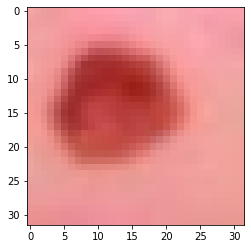

In [352]:
plt.imshow(shuffled_images[0])
print(shuffled_labels[0])

## Undersampling

# Image Data Generator

In [353]:
from keras.preprocessing.image import ImageDataGenerator

In [354]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=10,
    height_shift_range=10,
    brightness_range=(1, 1.8),
    #shear_range=5,
    zoom_range=0.1,
    #fill_mode = 'wrap',
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1/255.,
    #validation_split=0.2,
)

#train_gen = datagen.flow(data['train_images'], data['train_labels'], batch_size=32, subset='training')
#val_gen = datagen.flow(data['train_images'], data['train_labels'], batch_size=32, subset='validation')

In [355]:
from tqdm import tqdm

result = np.where(shuffled_labels == [6])
index_tmp = np.random.choice(result[0].shape[0], 4, replace=False)  
index = result[0][index_tmp]
shuffled_labels[index]
shuffled_images[index]

class_count = {}
new_images , new_labels = [], []

# count number of samples of each class 
for class_num in range(7):
  class_count[class_num] = np.count_nonzero(shuffled_labels == [class_num])

max_class_c = max(class_count.items(), key=operator.itemgetter(1))[1]
print(max_class_c)

for class_num, count in tqdm(class_count.items()):
  #print(count)
  result = np.where(shuffled_labels == [class_num])
  index_tmp = np.random.choice(result[0].shape[0], count, replace=False)  
  index = result[0][index_tmp]
  imgs = shuffled_images[index]
  lbls = shuffled_labels[index]

  #print(len(imgs), len(lbls))
  counter = 0
  diff = max_class_c - count
  train_gen = datagen.flow(imgs, lbls, batch_size=1)
  
  while counter < diff:
    #image = image.reshape((-1,) + image.shape)
    #train_gen = datagen.flow(image, [0], batch_size=1, shuffle=False)
    X, y = train_gen.next()
    new_images.append(np.array(X[0]))
    new_labels.append(y)

    counter += 1

6705


100%|██████████| 7/7 [00:32<00:00,  4.65s/it]


In [356]:
new_labels = np.array(new_labels).reshape(-1,1)
new_labels.shape

(36920, 1)

In [357]:
shuffled_labels.shape

(10015, 1)

In [358]:
# combine new data with older ones
combined_images = np.concatenate([shuffled_images, np.array(new_images)])
combined_labels = np.concatenate([shuffled_labels, np.array(new_labels)])
c = np.c_[combined_images.reshape(len(combined_images), -1), combined_labels.reshape(len(combined_labels), -1)]
# shuffle 
np.random.shuffle(c)
# split
shuffled_images = c[:, :combined_images.size//len(combined_images)].reshape(combined_images.shape)
shuffled_labels = c[:, combined_images.size//len(combined_images):].reshape(combined_labels.shape)

In [359]:
print(shuffled_images.shape)
print(shuffled_labels.shape)

(46935, 32, 32, 3)
(46935, 1)


In [360]:
# split train, val and test
[data['train_images'], data['val_images'], data['test_images']] = np.split(shuffled_images, [int(.8 * len(shuffled_images)), int(.9 * len(shuffled_images))])
[data['train_labels'], data['val_labels'], data['test_labels']] = np.split(shuffled_labels, [int(.8 * len(shuffled_labels)), int(.9 * len(shuffled_labels))])

In [361]:
for tag in list(data.keys())[:3]:
  # convert from integers to floats
  data[tag] = data[tag].astype('float32')
  # normalize to range 0-1
  #data[tag] /= 255

# one hot y values
for tag in list(data.keys())[3:]:
  data[tag] = to_categorical(data[tag])

In [362]:
data['test_images'].shape

(4694, 32, 32, 3)

# VGG Model

In [363]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *

In [364]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=data['train_images'][0].shape, kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.05))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
#model.add(Dropout(0.1))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(MaxPool2D((4, 4), strides=(2, 2)))
model.add(Dropout(0.05))

model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform'))
#model.add(Dropout(0.05))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 15, 15, 128)       147584    
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 6, 6, 128)       

In [365]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [366]:
data['train_images'].shape
data['train_labels'].shape

(37548, 7)

In [367]:
data['val_images'].shape
data['val_labels'].shape

(4693, 7)

In [368]:
history = model.fit(data['train_images'], data['train_labels'], batch_size=32, epochs=30, validation_data=(data['val_images'], data['val_labels']))

Epoch 1/30
1174/1174 [==============================] - 28s 23ms/step - loss: 6.2096 - acc: 0.2685 - val_loss: 2.7821 - val_acc: 0.3356
Epoch 2/30
1174/1174 [==============================] - 26s 22ms/step - loss: 2.6588 - acc: 0.3357 - val_loss: 2.3619 - val_acc: 0.4117
Epoch 3/30
1174/1174 [==============================] - 26s 22ms/step - loss: 2.2233 - acc: 0.4639 - val_loss: 2.1192 - val_acc: 0.4973
Epoch 4/30
1174/1174 [==============================] - 27s 23ms/step - loss: 2.0678 - acc: 0.5119 - val_loss: 2.0878 - val_acc: 0.4948
Epoch 5/30
1174/1174 [==============================] - 27s 23ms/step - loss: 1.9861 - acc: 0.5307 - val_loss: 2.1095 - val_acc: 0.4939
Epoch 6/30
1174/1174 [==============================] - 26s 22ms/step - loss: 1.9009 - acc: 0.5491 - val_loss: 1.8509 - val_acc: 0.5685
Epoch 7/30
1174/1174 [==============================] - 26s 22ms/step - loss: 1.8208 - acc: 0.5593 - val_loss: 1.7495 - val_acc: 0.5875
Epoch 8/30
1174/1174 [==========================

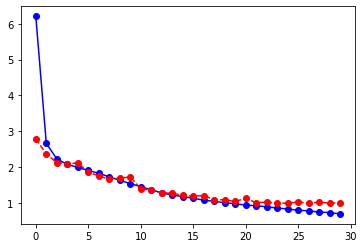

In [369]:
 plt.plot(history.history['loss'], 'b-o')
plt.plot(history.history['val_loss'], 'r--o')

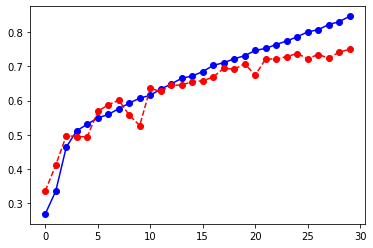

In [370]:
plt.plot(history.history['acc'], 'b-o')
plt.plot(history.history['val_acc'], 'r--o')

In [371]:
model.evaluate(data['test_images'], data['test_labels'])

147/147 [==============================] - 2s 11ms/step - loss: 1.0261 - acc: 0.7280


[1.0260721445083618, 0.7279505729675293]

[[447  75  83  24  72   2   1]
 [ 85 496  61  37  43   4   9]
 [100  50 343  28 178  22   4]
 [ 11  11  14 611  10   2   2]
 [ 40  21 110   2 345  44  16]
 [  4   6  29   4  45 564   4]
 [  0   9   5   2   8   0 611]]


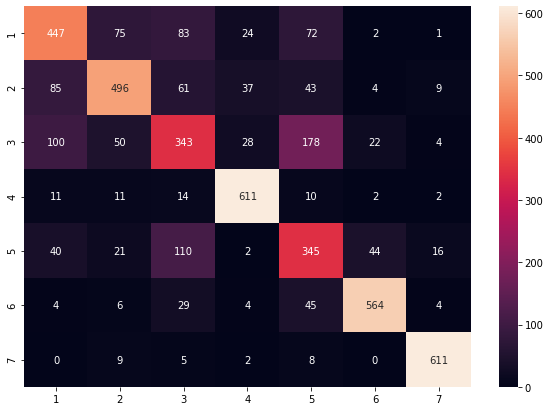

In [372]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import seaborn as sn


pred_test_values = np.argmax(model.predict(data['test_images']), axis=1)
y_test_arg = np.argmax(data['test_labels'], axis=1)

cm = confusion_matrix(pred_test_values, y_test_arg)
print(cm)

target_labels = '1234567'
df_cm = pd.DataFrame(cm, index = [i for i in target_labels],
                  columns = [i for i in target_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

In [373]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test_arg, pred_test_values, target_names=target_labels, digits=4))

              precision    recall  f1-score   support

           1     0.6349    0.6507    0.6427       687
           2     0.6748    0.7425    0.7071       668
           3     0.4731    0.5318    0.5007       645
           4     0.9244    0.8630    0.8926       708
           5     0.5969    0.4922    0.5395       701
           6     0.8598    0.8840    0.8717       638
           7     0.9622    0.9444    0.9532       647

    accuracy                         0.7280      4694
   macro avg     0.7323    0.7298    0.7296      4694
weighted avg     0.7320    0.7280    0.7286      4694

